In [1]:
import numpy as np
import pandas as pd
import soundfile as sf
import datetime as dt
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from pytz import timezone

from pathlib import Path

In [2]:
import sys

# # append the path of the
# # parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

In [3]:
import src.subsampling as ss

In [4]:
input_dir = f'{Path.home()}/Documents/Research/Symposium/Recordings/recover-20220828/UBNA_010'
summer_audio_files = sorted(list(Path(input_dir).iterdir()))
date = "20220826"
# dates = ["20220726", "20220826", "20220827", "20220828", "20220829", "20221014", "20221015", "20221016", "20221017"]
dates = ["20220826", "20220827", "20220828", "20220829"]
# dates = ["20220826"]
# dates = ["20221014", "20221015", "20221016", "20221017"]
# dates = ["20221014", "20221015", "20221016"]
location = "Central Pond"

In [5]:
times = ["030000", "033000", "040000", "043000",
         "050000", "053000", "060000", "063000",
         "070000", "073000", "080000", "083000",
         "090000", "093000", "100000", "103000",
         "110000", "113000", "120000", "123000",
         "130000"]
presence_threshold = 1

labels = []
for f_date in dates:
    for time in times:
        labels.append(f'{f_date}_{time}.WAV')

datetime_hour_min_info = []
datetime_date_info = set()
for label in labels:
    date_and_time = dt.datetime.strptime(label, '%Y%m%d_%H%M%S.WAV')
    if (date_and_time.hour < 7):
        date_and_time_PST = dt.datetime(date_and_time.year, date_and_time.month, date_and_time.day - 1, 24 + date_and_time.hour - 7, date_and_time.minute, date_and_time.second)
    else:
        date_and_time_PST = dt.datetime(date_and_time.year, date_and_time.month, date_and_time.day, date_and_time.hour - 7, date_and_time.minute, date_and_time.second)
    datetime_hour_min_info.append(dt.datetime.strftime(date_and_time_PST, "%H:%M"))
    datetime_date_info.add(dt.datetime.strftime(date_and_time, "%b-%d"))

datetime_hour_min_info

['20:00',
 '20:30',
 '21:00',
 '21:30',
 '22:00',
 '22:30',
 '23:00',
 '23:30',
 '00:00',
 '00:30',
 '01:00',
 '01:30',
 '02:00',
 '02:30',
 '03:00',
 '03:30',
 '04:00',
 '04:30',
 '05:00',
 '05:30',
 '06:00',
 '20:00',
 '20:30',
 '21:00',
 '21:30',
 '22:00',
 '22:30',
 '23:00',
 '23:30',
 '00:00',
 '00:30',
 '01:00',
 '01:30',
 '02:00',
 '02:30',
 '03:00',
 '03:30',
 '04:00',
 '04:30',
 '05:00',
 '05:30',
 '06:00',
 '20:00',
 '20:30',
 '21:00',
 '21:30',
 '22:00',
 '22:30',
 '23:00',
 '23:30',
 '00:00',
 '00:30',
 '01:00',
 '01:30',
 '02:00',
 '02:30',
 '03:00',
 '03:30',
 '04:00',
 '04:30',
 '05:00',
 '05:30',
 '06:00',
 '20:00',
 '20:30',
 '21:00',
 '21:30',
 '22:00',
 '22:30',
 '23:00',
 '23:30',
 '00:00',
 '00:30',
 '01:00',
 '01:30',
 '02:00',
 '02:30',
 '03:00',
 '03:30',
 '04:00',
 '04:30',
 '05:00',
 '05:30',
 '06:00']

In [6]:
def get_dets_from_csv_files(date, location):
    dets1 = pd.read_csv(f"../output_dir/1min_every_6min__{location.split()[0]}_{date}_030000to130000.csv")
    dets2 = pd.read_csv(f"../output_dir/5min_every_30min__{location.split()[0]}_{date}_030000to130000.csv")
    c_dets = pd.read_csv(f"../output_dir/continuous__{location.split()[0]}_{date}_030000to130000.csv")

    return c_dets, dets1, dets2

def get_dets_lfdets_and_hfdets(dets, filename):
    detects = dets[dets['input_file']==filename]
    lfdetects = detects[detects["high_freq"] < 45000]
    hfdetects = detects[detects["low_freq"] > 35000]

    return detects, lfdetects, hfdetects

def add_num_to_buckets(bucket1, bucket2, bucket3, num1, num2, num3):
    bucket1 = np.hstack([bucket1, [num1]])
    bucket2 = np.hstack([bucket2, [num2]])
    bucket3 = np.hstack([bucket3, [num3]])

    return bucket1, bucket2, bucket3

def get_presence_from_numdets(num_dets, num_lfdets, num_hfdets, presence_threshold):
    presence = np.ones(num_dets.shape[0])
    presence[num_dets < presence_threshold] = 0
    lfpresence = np.ones(num_lfdets.shape[0])
    lfpresence[num_lfdets < presence_threshold] = 0
    hfpresence = np.ones(num_hfdets.shape[0])
    hfpresence[num_hfdets < presence_threshold] = 0

    return presence, lfpresence, hfpresence

In [7]:
presence1_over_days = np.array([])
lfpresence1_over_days = np.array([])
hfpresence1_over_days = np.array([])

presence2_over_days = np.array([])
lfpresence2_over_days = np.array([])
hfpresence2_over_days = np.array([])

c_presence_over_days = np.array([])
c_lfpresence_over_days = np.array([])
c_hfpresence_over_days = np.array([])

for i, f_date in enumerate(dates):
    num_c_dets = np.array([])
    num_dets2 = np.array([])
    num_dets1 = np.array([])

    num_lfdets1 = np.array([])
    num_lfdets2 = np.array([])
    num_c_lfdets = np.array([])

    num_hfdets1 = np.array([])
    num_hfdets2 = np.array([])
    num_c_hfdets = np.array([])

    c_dets, dets, dets2 = get_dets_from_csv_files(f_date, location)

    for label in labels:
        if (label[:8] == f_date):
            detects1, lfdetects1, hfdetects1 = get_dets_lfdets_and_hfdets(dets, label)
            num_dets1, num_lfdets1, num_hfdets1 = add_num_to_buckets(num_dets1, num_lfdets1, num_hfdets1, 
                                                                    detects1.shape[0], lfdetects1.shape[0], hfdetects1.shape[0])
            
            detects2, lfdetects2, hfdetects2 = get_dets_lfdets_and_hfdets(dets2, label)
            num_dets2, num_lfdets2, num_hfdets2 = add_num_to_buckets(num_dets2, num_lfdets2, num_hfdets2, 
                                                                    detects2.shape[0], lfdetects2.shape[0], hfdetects2.shape[0])
            

            cdetects, c_lfdetects, c_hfdetects = get_dets_lfdets_and_hfdets(c_dets, label)
            num_c_dets, num_c_lfdets, num_c_hfdets = add_num_to_buckets(num_c_dets, num_c_lfdets, num_c_hfdets, 
                                                                    cdetects.shape[0], c_lfdetects.shape[0], c_hfdetects.shape[0])

    presence1, lfpresence1, hfpresence1 = get_presence_from_numdets(num_dets1, num_lfdets1, num_hfdets1, presence_threshold)
    presence2, lfpresence2, hfpresence2 = get_presence_from_numdets(num_dets2, num_lfdets2, num_hfdets2, presence_threshold)
    c_presence, c_lfpresence, c_hfpresence = get_presence_from_numdets(num_c_dets, num_c_lfdets, num_c_hfdets, presence_threshold)

    if (i==0):
        presence1_over_days = np.hstack((presence1_over_days, presence1))
        lfpresence1_over_days = np.hstack((lfpresence1_over_days, lfpresence1))
        hfpresence1_over_days = np.hstack((hfpresence1_over_days, hfpresence1))

        presence2_over_days = np.hstack((presence2_over_days, presence2))
        lfpresence2_over_days = np.hstack((lfpresence2_over_days, lfpresence2))
        hfpresence2_over_days = np.hstack((hfpresence2_over_days, hfpresence2))

        c_presence_over_days = np.hstack((c_presence_over_days, c_presence))
        c_lfpresence_over_days = np.hstack((c_lfpresence_over_days, c_lfpresence))
        c_hfpresence_over_days = np.hstack((c_hfpresence_over_days, c_hfpresence))
    else:
        presence1_over_days = np.vstack((presence1_over_days, presence1))
        lfpresence1_over_days = np.vstack((lfpresence1_over_days, lfpresence1))
        hfpresence1_over_days = np.vstack((hfpresence1_over_days, hfpresence1))

        presence2_over_days = np.vstack((presence2_over_days, presence2))
        lfpresence2_over_days = np.vstack((lfpresence2_over_days, lfpresence2))
        hfpresence2_over_days = np.vstack((hfpresence2_over_days, hfpresence2))

        c_presence_over_days = np.vstack((c_presence_over_days, c_presence))
        c_lfpresence_over_days = np.vstack((c_lfpresence_over_days, c_lfpresence))
        c_hfpresence_over_days = np.vstack((c_hfpresence_over_days, c_hfpresence))


if (len(c_presence_over_days.shape) == 1):
    c_presence_over_days = c_presence_over_days.reshape((1, 21))
if (len(presence1_over_days.shape) == 1):    
    presence1_over_days = presence1_over_days.reshape((1, 21))
if (len(presence2_over_days.shape) == 1):       
    presence2_over_days = presence2_over_days.reshape((1, 21))

if (len(c_lfpresence_over_days.shape) == 1):
    c_lfpresence_over_days = c_lfpresence_over_days.reshape((1, 21))
if (len(lfpresence1_over_days.shape) == 1):    
    lfpresence1_over_days = lfpresence1_over_days.reshape((1, 21))
if (len(lfpresence2_over_days.shape) == 1):       
    lfpresence2_over_days = lfpresence2_over_days.reshape((1, 21))

if (len(c_hfpresence_over_days.shape) == 1):
    c_hfpresence_over_days = c_hfpresence_over_days.reshape((1, 21))
if (len(hfpresence1_over_days.shape) == 1):    
    hfpresence1_over_days = hfpresence1_over_days.reshape((1, 21))
if (len(hfpresence2_over_days.shape) == 1):       
    hfpresence2_over_days = hfpresence2_over_days.reshape((1, 21))

times = datetime_hour_min_info[:21]
times

['20:00',
 '20:30',
 '21:00',
 '21:30',
 '22:00',
 '22:30',
 '23:00',
 '23:30',
 '00:00',
 '00:30',
 '01:00',
 '01:30',
 '02:00',
 '02:30',
 '03:00',
 '03:30',
 '04:00',
 '04:30',
 '05:00',
 '05:30',
 '06:00']

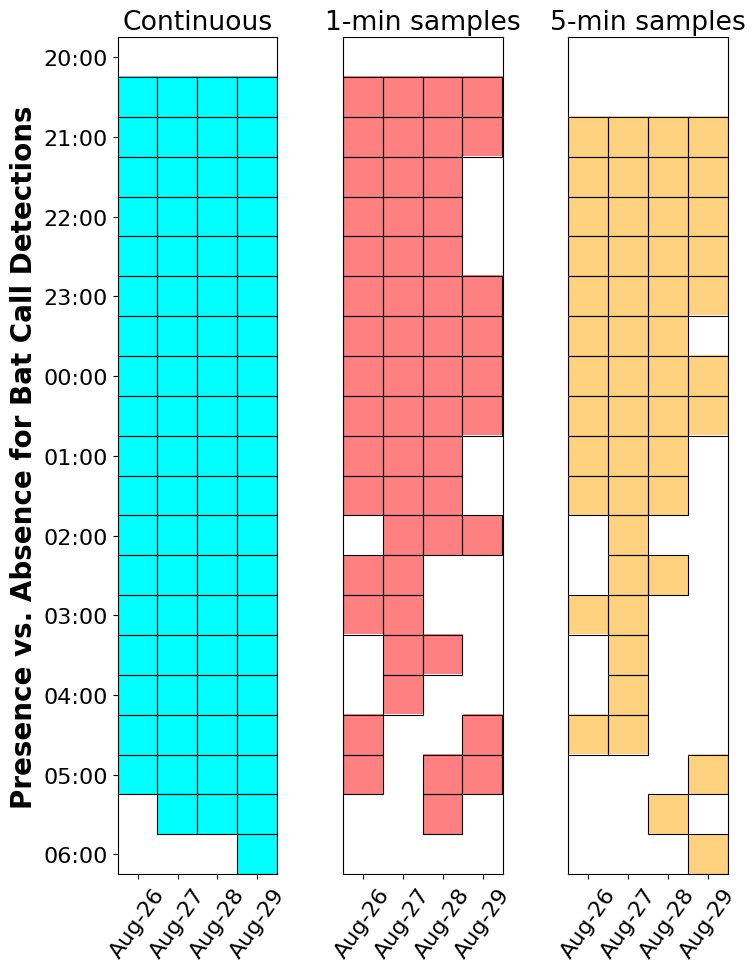

In [9]:
def rect(pos):
    r = plt.Rectangle(pos-0.505, 1, 1, facecolor="none", edgecolor="k", linewidth=0.8)
    plt.gca().add_patch(r)

plt.figure(figsize=(8, 10))
plt.rcParams.update({'font.size': 16})

datetime_info = times
date_info = sorted(list(datetime_date_info))

time_ticks = np.arange(c_presence_over_days.shape[1])[::2]
date_ticks = np.arange(c_presence_over_days.shape[0])

plt.subplot(131)
plt.title("Continuous")
plt.ylabel("Presence vs. Absence for Bat Call Detections", fontsize=20, fontweight='bold')
plot_cp_overdays = c_presence_over_days.T
masked_array = np.ma.masked_where(plot_cp_overdays == 1, plot_cp_overdays)
cmap = plt.get_cmap("Greys")  # Can be any colormap that you want after the cm
cmap.set_bad(color='cyan')
im = plt.imshow(masked_array, cmap=cmap)
x, y = np.meshgrid(np.arange(plot_cp_overdays.shape[1]), np.arange(plot_cp_overdays.shape[0]))
m = np.c_[x[plot_cp_overdays == 1], y[plot_cp_overdays == 1]]
for pos in m:
     rect(pos)
plt.yticks(time_ticks, datetime_info[::2])
plt.xticks(date_ticks, date_info, rotation=55)

plt.subplot(132)
plt.title("1-min samples")
plot_p1_overdays = presence1_over_days.T
masked_array = np.ma.masked_where(plot_p1_overdays == 1, plot_p1_overdays)
cmap = plt.get_cmap("Greys")  # Can be any colormap that you want after the cm
cmap.set_bad(color='red', alpha=0.5)
im = plt.imshow(masked_array, cmap=cmap)
x, y = np.meshgrid(np.arange(plot_p1_overdays.shape[1]), np.arange(plot_p1_overdays.shape[0]))
m = np.c_[x[plot_p1_overdays == 1], y[plot_p1_overdays == 1]]
for pos in m:
    rect(pos)
plt.yticks([], [])
plt.xticks(date_ticks, date_info, rotation=55)

plt.subplot(133)
plt.title("5-min samples")
plot_p2_overdays = presence2_over_days.T
masked_array = np.ma.masked_where(plot_p2_overdays == 1, plot_p2_overdays)
cmap = plt.get_cmap("Greys")  # Can be any colormap that you want after the cm
cmap.set_bad(color='orange', alpha=0.5)
im = plt.imshow(masked_array, cmap=cmap)
x, y = np.meshgrid(np.arange(plot_p2_overdays.shape[1]), np.arange(plot_p2_overdays.shape[0]))
m = np.c_[x[plot_p2_overdays == 1], y[plot_p2_overdays == 1]]
for pos in m:
    rect(pos)
plt.yticks([], [])
plt.xticks(date_ticks, date_info, rotation=55)

plt.tight_layout()
plt.savefig(f'{Path.home()}/Documents/Research/Symposium/Figures/lf_&_hf_presence_absence_grid__{location.split()[0]}_{dates[-1]}_030000to130000_comparisons.png')
plt.show()

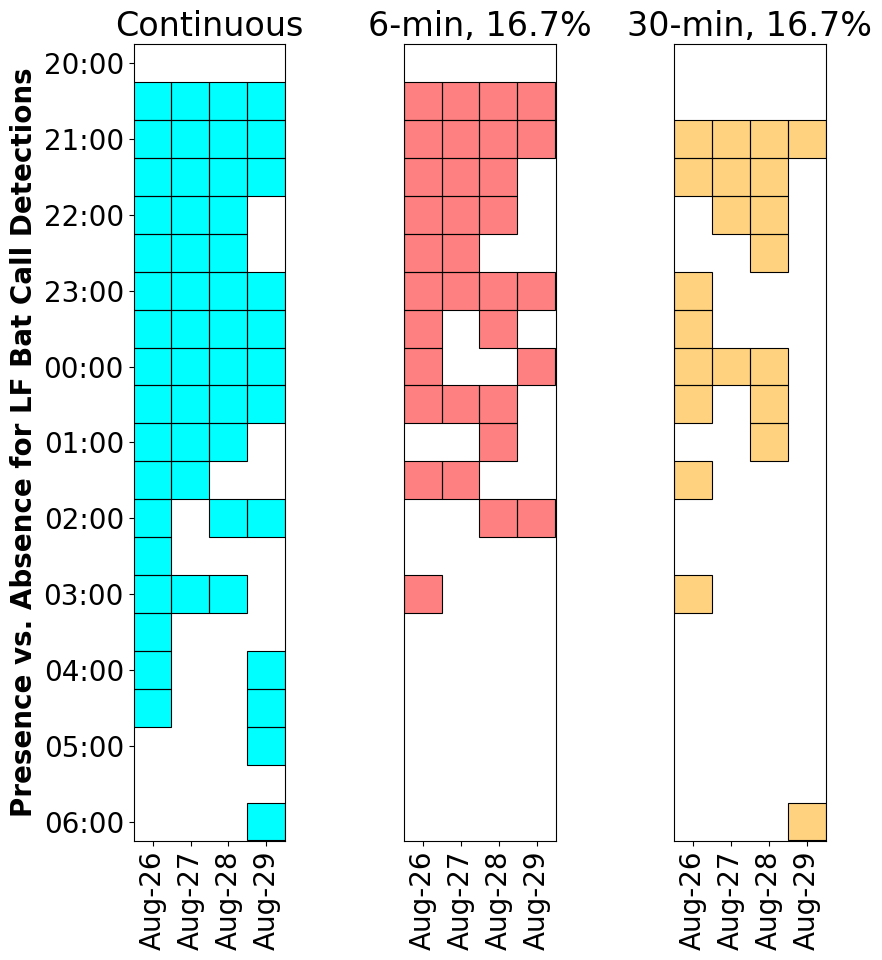

In [11]:
plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 20})

plt.subplot(131)
plt.title("Continuous")
plt.ylabel("Presence vs. Absence for LF Bat Call Detections", fontsize=20, fontweight='bold')
plot_cp_overdays = c_lfpresence_over_days.T
masked_array = np.ma.masked_where(plot_cp_overdays == 1, plot_cp_overdays)
cmap = plt.get_cmap("Greys")  # Can be any colormap that you want after the cm
cmap.set_bad(color='cyan')
im = plt.imshow(masked_array, cmap=cmap)
x, y = np.meshgrid(np.arange(plot_cp_overdays.shape[1]), np.arange(plot_cp_overdays.shape[0]))
m = np.c_[x[plot_cp_overdays == 1], y[plot_cp_overdays == 1]]
for pos in m:
    rect(pos)
plt.yticks(time_ticks, datetime_info[::2])
plt.xticks(date_ticks, date_info, rotation=90)

plt.subplot(132)
plt.title("6-min, 16.7%")
plot_p1_overdays = lfpresence1_over_days.T
masked_array = np.ma.masked_where(plot_p1_overdays == 1, plot_p1_overdays)
cmap = plt.get_cmap("Greys")  # Can be any colormap that you want after the cm
cmap.set_bad(color='red', alpha=0.5)
im = plt.imshow(masked_array, cmap=cmap)
x, y = np.meshgrid(np.arange(plot_p1_overdays.shape[1]), np.arange(plot_p1_overdays.shape[0]))
m = np.c_[x[plot_p1_overdays == 1], y[plot_p1_overdays == 1]]
for pos in m:
    rect(pos)
plt.yticks([], [])
plt.xticks(date_ticks, date_info, rotation=90)

plt.subplot(133)
plt.title("30-min, 16.7%")
plot_p2_overdays = lfpresence2_over_days.T
masked_array = np.ma.masked_where(plot_p2_overdays == 1, plot_p2_overdays)
cmap = plt.get_cmap("Greys")  # Can be any colormap that you want after the cm
cmap.set_bad(color='orange', alpha=0.5)
im = plt.imshow(masked_array, cmap=cmap)
x, y = np.meshgrid(np.arange(plot_p2_overdays.shape[1]), np.arange(plot_p2_overdays.shape[0]))
m = np.c_[x[plot_p2_overdays == 1], y[plot_p2_overdays == 1]]
for pos in m:
    rect(pos)
plt.yticks([], [])
plt.xticks(date_ticks, date_info, rotation=90)

plt.tight_layout()
plt.savefig(f'{Path.home()}/Documents/Research/Symposium/Figures/lf_presence_absence_grid__{location.split()[0]}_{dates[-1]}_030000to130000_comparisons.png')
plt.show()

In [12]:
new_date_info = []
new_date_info.append(datetime_info[0])
for info in datetime_info[2::2]:
    new_date_info.append('')
    new_date_info.append(info)

new_date_info.append('')
new_date_info

['20:00',
 '',
 '21:00',
 '',
 '22:00',
 '',
 '23:00',
 '',
 '00:00',
 '',
 '01:00',
 '',
 '02:00',
 '',
 '03:00',
 '',
 '04:00',
 '',
 '05:00',
 '',
 '06:00',
 '']

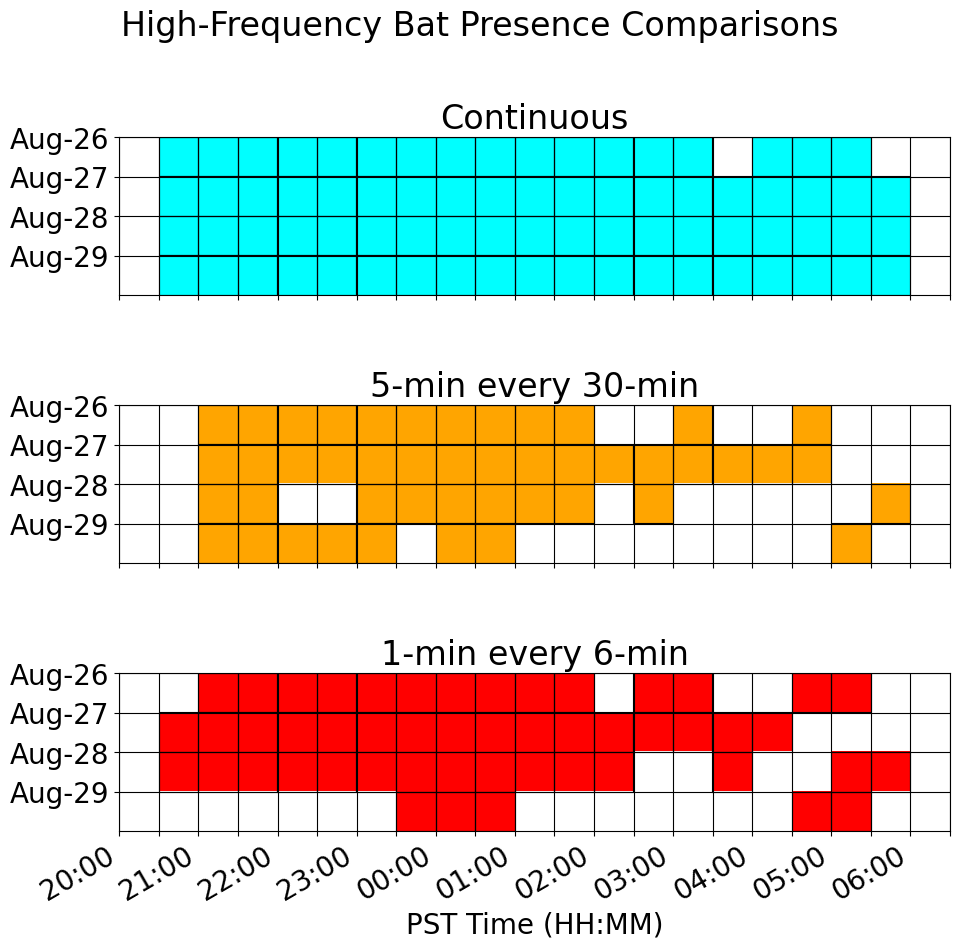

In [14]:
plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 20})
plt.suptitle("High-Frequency Bat Presence Comparisons")

plt.subplot(311)
plt.title("Continuous")
plot_cp_overdays = c_hfpresence_over_days
masked_array = np.ma.masked_where(plot_cp_overdays == 1, plot_cp_overdays)
cmap = plt.get_cmap("Greys")  # Can be any colormap that you want after the cm
cmap.set_bad(color='cyan')
im = plt.imshow(masked_array, cmap=cmap)
x, y = np.meshgrid(np.arange(plot_cp_overdays.shape[1]), np.arange(plot_cp_overdays.shape[0]))
m = np.c_[x[plot_cp_overdays == 1], y[plot_cp_overdays == 1]]
for pos in m:
    rect(pos)
plt.xticks(np.arange(c_presence_over_days.shape[1]+1)-0.5, new_date_info)
plt.xlabel("PST Time (HH:MM)", fontsize=20)
plt.yticks(date_ticks-0.5, date_info)
plt.grid(which="both", color='k')

plt.subplot(312)
plt.title("5-min every 30-min")
plot_p2_overdays = hfpresence2_over_days
masked_array = np.ma.masked_where(plot_p2_overdays == 1, plot_p2_overdays)
cmap = plt.get_cmap("Greys")  # Can be any colormap that you want after the cm
cmap.set_bad(color='orange')
im = plt.imshow(masked_array, cmap=cmap)
x, y = np.meshgrid(np.arange(plot_p2_overdays.shape[1]), np.arange(plot_p2_overdays.shape[0]))
m = np.c_[x[plot_p2_overdays == 1], y[plot_p2_overdays == 1]]
for pos in m:
    rect(pos)
plt.xlabel("PST Time (HH:MM)", fontsize=20)
plt.yticks(date_ticks-0.5, date_info)
plt.xticks(np.arange(c_presence_over_days.shape[1]+1)-0.5, new_date_info)
plt.grid(which="both", color='k')

plt.subplot(313)
plt.title("1-min every 6-min")
plot_p1_overdays = hfpresence1_over_days
masked_array = np.ma.masked_where(plot_p1_overdays == 1, plot_p1_overdays)
cmap = plt.get_cmap("Greys")  # Can be any colormap that you want after the cm
cmap.set_bad(color='red')
im = plt.imshow(masked_array, cmap=cmap)
x, y = np.meshgrid(np.arange(plot_p1_overdays.shape[1]), np.arange(plot_p1_overdays.shape[0]))
m = np.c_[x[plot_p1_overdays == 1], y[plot_p1_overdays == 1]]
for pos in m:
    rect(pos)
plt.xticks(np.arange(c_presence_over_days.shape[1]+1)-0.5, new_date_info)
plt.xlabel("PST Time (HH:MM)", fontsize=20)
plt.yticks(date_ticks-0.5, date_info)
plt.grid(which="both", color='k')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.savefig(f'{Path.home()}/Documents/Research/Symposium/Figures/hf_presence_absence_grid__{location.split()[0]}_{dates[-1]}_030000to130000_comparisons.png')
plt.show()

In [15]:
bar_alpha = 0.5
continuous_bar_color = 'cyan'
comparison_6min_bar_color = 'red'
comparison_30min_bar_color = 'orange'
y_label_fontsize = 16
x_label_fontsize = 16
bar_edgecolor = 'black'
bar_width = 1

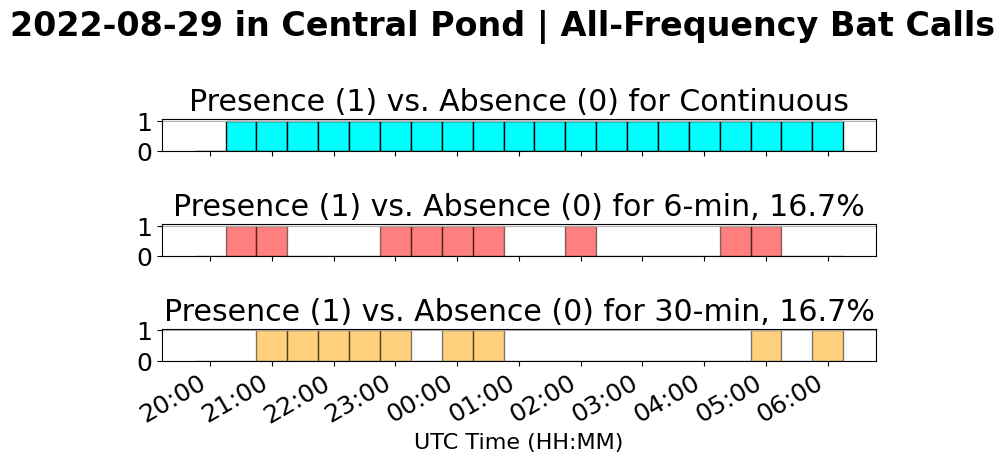

In [17]:
plt.figure(figsize=(8, 4.8))
plt.rcParams.update({'font.size': 18})

plot_date = (dt.datetime.strptime(dates[-1], '%Y%m%d')).date()
plt.suptitle(f"{plot_date} in {location} | All-Frequency Bat Calls", fontsize=24, fontweight='bold')

plt.subplot(311)
plt.title(f"Presence (1) vs. Absence (0) for Continuous")
plt.bar(datetime_info, c_presence, width=bar_width, color=continuous_bar_color, edgecolor=bar_edgecolor)
plt.xlabel("UTC Time (HH:MM)", fontsize=x_label_fontsize)
plt.grid(axis="y")
plt.yticks([0, 1], [0, 1])
plt.xticks(np.arange(0, 21, 2), datetime_info[::2], rotation=30)

plt.subplot(312)
plt.title(f"Presence (1) vs. Absence (0) for 6-min, 16.7%")
plt.bar(datetime_info, presence1, width=bar_width, color=comparison_6min_bar_color, edgecolor=bar_edgecolor, alpha=bar_alpha)
plt.xlabel("UTC Time (HH:MM)", fontsize=x_label_fontsize)
plt.grid(axis="y")
plt.yticks([0, 1], [0, 1])
plt.xticks(np.arange(0, 21, 2), datetime_info[::2], rotation=30)

plt.subplot(313)
plt.title(f"Presence (1) vs. Absence (0) for 30-min, 16.7%")
plt.bar(datetime_info, presence2, width=bar_width, color=comparison_30min_bar_color, edgecolor=bar_edgecolor, alpha=bar_alpha)
plt.xlabel("UTC Time (HH:MM)", fontsize=x_label_fontsize)
plt.grid(axis="y")
plt.yticks([0, 1], [0, 1])
plt.xticks(np.arange(0, 21, 2), datetime_info[::2], rotation=30)

plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.savefig(f'{Path.home()}/Documents/Research/Symposium/Figures/lf_&_hf_presence_absence__{location.split()[0]}_{dates[-1]}_030000to130000_comparisons.png')
plt.show()

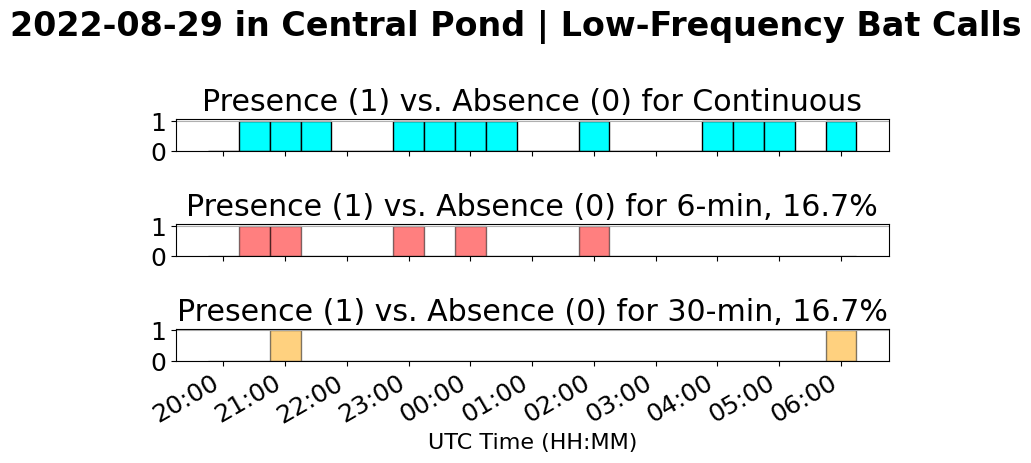

In [19]:
plt.figure(figsize=(8, 4.8))

plt.suptitle(f"{plot_date} in {location} | Low-Frequency Bat Calls", fontsize=24, fontweight='bold')

plt.subplot(311)
plt.title(f"Presence (1) vs. Absence (0) for Continuous")
plt.bar(datetime_info, c_lfpresence, width=bar_width, color=continuous_bar_color, edgecolor=bar_edgecolor)
plt.xlabel("UTC Time (HH:MM)", fontsize=x_label_fontsize)
plt.grid(axis="y")
plt.yticks([0, 1], [0, 1])
plt.xticks(np.arange(0, 21, 2), datetime_info[::2], rotation=30)

plt.subplot(312)
plt.title(f"Presence (1) vs. Absence (0) for 6-min, 16.7%")
plt.bar(datetime_info, lfpresence1, width=bar_width, color=comparison_6min_bar_color, edgecolor=bar_edgecolor, alpha=bar_alpha)
plt.xlabel("UTC Time (HH:MM)", fontsize=x_label_fontsize)
plt.grid(axis="y")
plt.yticks([0, 1], [0, 1])
plt.xticks(np.arange(0, 21, 2), datetime_info[::2], rotation=30)

plt.subplot(313)
plt.title(f"Presence (1) vs. Absence (0) for 30-min, 16.7%")
plt.bar(datetime_info, lfpresence2, width=bar_width, color=comparison_30min_bar_color, edgecolor=bar_edgecolor, alpha=bar_alpha)
plt.xlabel("UTC Time (HH:MM)", fontsize=x_label_fontsize)
plt.grid(axis="y")
plt.yticks([0, 1], [0, 1])
plt.xticks(np.arange(0, 21, 2), datetime_info[::2], rotation=30)

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.savefig(f'{Path.home()}/Documents/Research/Symposium/Figures/lf_presence_absence__{location.split()[0]}_{dates[-1]}_030000to130000_comparisons.png')
plt.show()

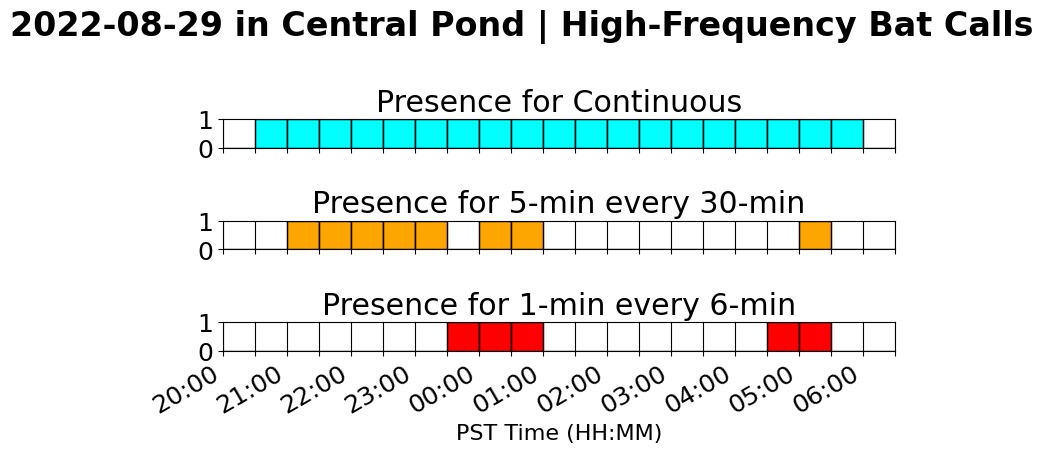

In [28]:
plt.figure(figsize=(8, 4.7))

plt.suptitle(f"{plot_date} in {location} | High-Frequency Bat Calls", fontsize=24, fontweight='bold')
plt.subplot(311)
plt.title(f"Presence for Continuous")
plt.bar(datetime_info, c_hfpresence, width=bar_width, color=continuous_bar_color, edgecolor=bar_edgecolor)
plt.xlabel("UTC Time (HH:MM)", fontsize=x_label_fontsize)
plt.yticks([0, 1], [0, 1])
plt.ylim(0, 1)
plt.xlim(0, 20.5)
plt.xticks(np.arange(c_presence_over_days.shape[1]+1)-0.5, new_date_info)
plt.grid(axis="x", color='k')

plt.subplot(312)
plt.title(f"Presence for 5-min every 30-min")
plt.bar(datetime_info, hfpresence2, width=bar_width, color=comparison_30min_bar_color, edgecolor=bar_edgecolor)
plt.xlabel("PST Time (HH:MM)", fontsize=x_label_fontsize)
plt.yticks([0, 1], [0, 1])
plt.ylim(0, 1)
plt.xlim(0, 20.5)
plt.xticks(np.arange(c_presence_over_days.shape[1]+1)-0.5, new_date_info)
plt.grid(axis="x", color='k')

plt.subplot(313)
plt.title(f"Presence for 1-min every 6-min")
plt.bar(datetime_info, hfpresence1, width=bar_width, color=comparison_6min_bar_color, edgecolor=bar_edgecolor)
plt.xlabel("PST Time (HH:MM)", fontsize=x_label_fontsize)
plt.yticks([0, 1], [0, 1])
plt.ylim(0, 1)
plt.xlim(0, 20.5)
plt.xticks(np.arange(c_presence_over_days.shape[1]+1)-0.5, new_date_info)
plt.grid(axis="x", color='k')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.savefig(f'{Path.home()}/Documents/Research/Symposium/Figures/hf_presence_absence__{location.split()[0]}_{dates[-1]}_030000to130000_comparisons.png')
plt.show()

In [29]:
bar_alpha = 0.5
continuous_bar_color = 'cyan'
comparison_6min_bar_color = 'red'
comparison_30min_bar_color = 'orange'
legend_loc = 1
bar_edgecolor = 'black'
bar_width = 0.5

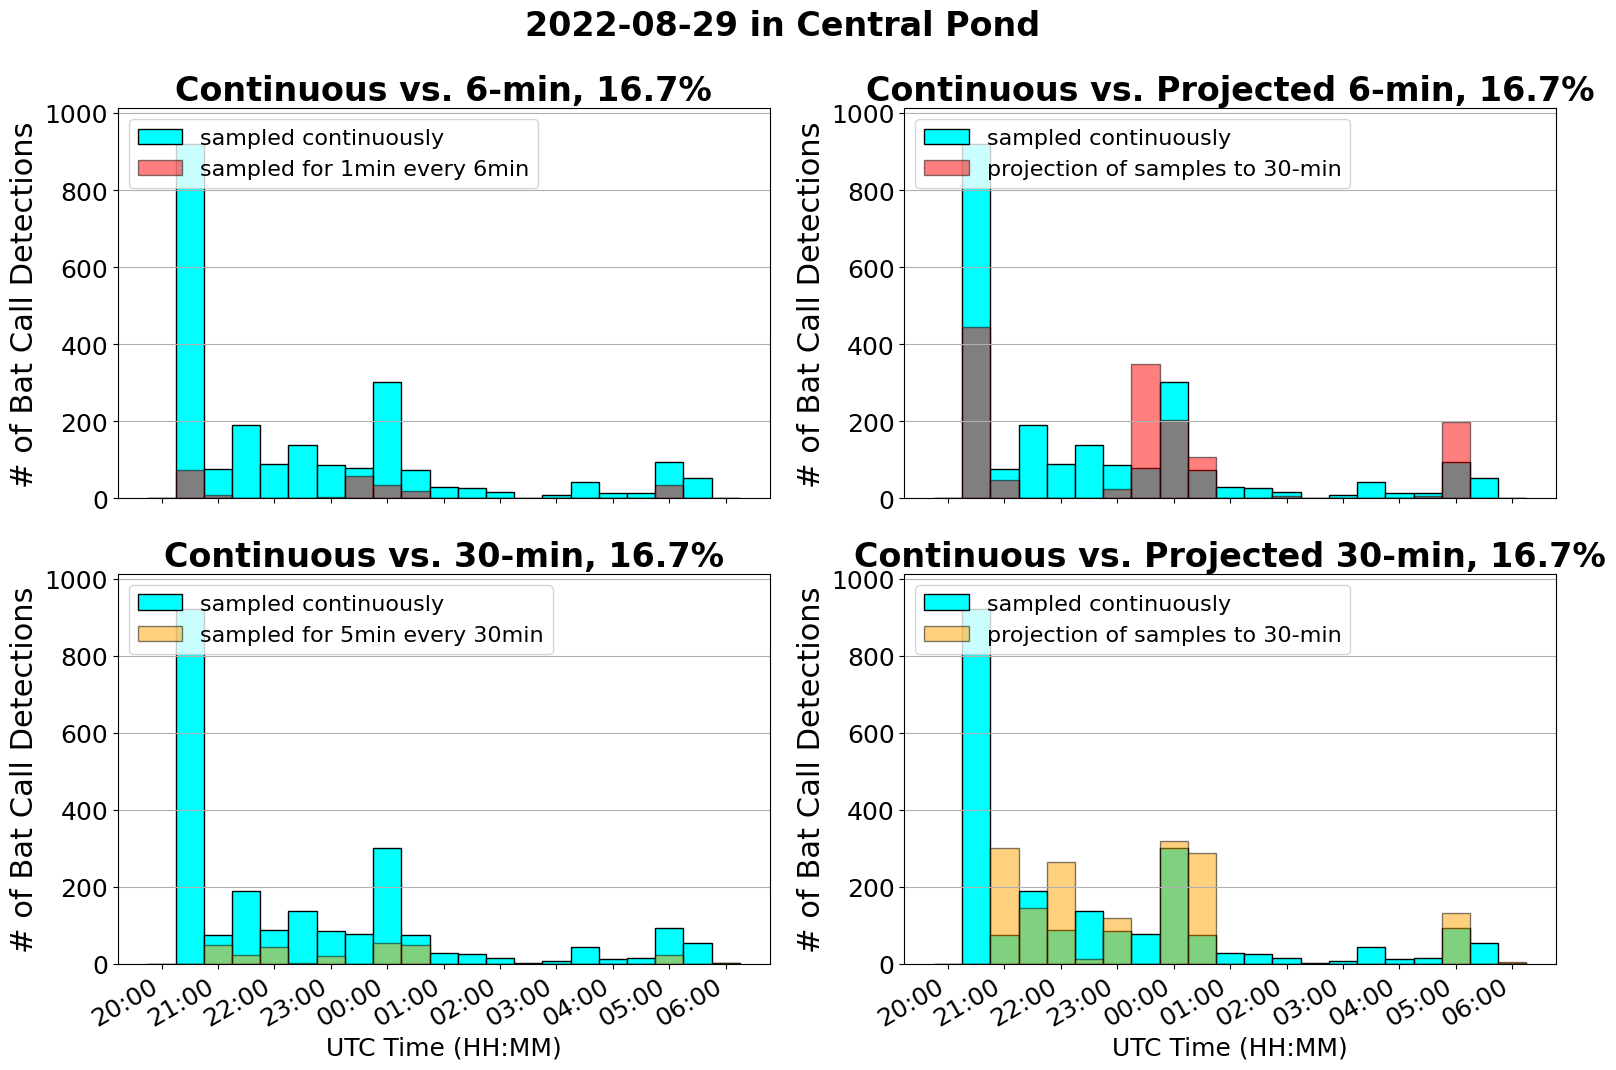

In [31]:
plt.figure(figsize=(16, 11))
plt.rcParams.update({'font.size': 18})
legend_loc = 2
plt.suptitle(f"{plot_date} in {location}", fontsize=24, fontweight='bold') 

plt.subplot(221)
plt.title(f"Continuous vs. 6-min, 16.7%", fontsize=24, fontweight='bold')
plt.ylabel("# of Bat Call Detections", fontsize=22)
plt.xlabel("UTC Time (HH:MM)")
plt.bar(datetime_info, height=num_c_dets, width=1, label="sampled continuously", color=continuous_bar_color, edgecolor=bar_edgecolor)
plt.bar(datetime_info, height=num_dets1, width=1, label="sampled for 1min every 6min", color=comparison_6min_bar_color, alpha=bar_alpha, edgecolor=bar_edgecolor)
plt.grid(axis="y")
plt.ylim(0, 1.1*max(np.max(num_c_dets), np.max(6*num_dets1), np.max(6*num_dets2)))
plt.legend(loc=legend_loc, fontsize=16)
plt.xticks(np.arange(0, 21, 2), datetime_info[::2])

plt.subplot(222)
plt.title(f"Continuous vs. Projected 6-min, 16.7%", fontsize=24, fontweight='bold')
plt.ylabel("# of Bat Call Detections", fontsize=22)
plt.xlabel("UTC Time (HH:MM)")
plt.bar(datetime_info, height=num_c_dets, width=1, label="sampled continuously", color=continuous_bar_color, edgecolor=bar_edgecolor)
plt.bar(datetime_info, height=num_dets1*6, width=1, label="projection of samples to 30-min", color=comparison_6min_bar_color, alpha=bar_alpha, edgecolor=bar_edgecolor)
plt.grid(axis="y")
plt.ylim(0, 1.1*max(np.max(num_c_dets), np.max(6*num_dets1), np.max(6*num_dets2)))
plt.legend(loc=legend_loc, fontsize=16)
plt.xticks(np.arange(0, 21, 2), datetime_info[::2])

plt.subplot(223)
plt.title(f"Continuous vs. 30-min, 16.7%", fontsize=24, fontweight='bold')
plt.ylabel("# of Bat Call Detections", fontsize=22)
plt.xlabel("UTC Time (HH:MM)")
plt.bar(datetime_info, height=num_c_dets, width=1, label="sampled continuously", color=continuous_bar_color, edgecolor=bar_edgecolor)
plt.bar(datetime_info, height=num_dets2, width=1, label="sampled for 5min every 30min", color=comparison_30min_bar_color, alpha=bar_alpha, edgecolor=bar_edgecolor)
plt.grid(axis="y")
plt.ylim(0, 1.1*max(np.max(num_c_dets), np.max(6*num_dets1), np.max(6*num_dets2)))
plt.legend(loc=legend_loc, fontsize=16)
plt.xticks(np.arange(0, 21, 2), datetime_info[::2])

plt.subplot(224)
plt.title(f"Continuous vs. Projected 30-min, 16.7%", fontsize=24, fontweight='bold')
plt.ylabel("# of Bat Call Detections", fontsize=22)
plt.xlabel("UTC Time (HH:MM)")
plt.bar(datetime_info, height=num_c_dets, width=1, label="sampled continuously", color=continuous_bar_color, edgecolor=bar_edgecolor)
plt.bar(datetime_info, height=num_dets2*6, width=1, label="projection of samples to 30-min", color=comparison_30min_bar_color, alpha=bar_alpha, edgecolor=bar_edgecolor)
plt.grid(axis="y")
plt.ylim(0, 1.1*max(np.max(num_c_dets), np.max(6*num_dets1), np.max(6*num_dets2)))
plt.legend(loc=legend_loc, fontsize=16)
plt.xticks(np.arange(0, 21, 2), datetime_info[::2])
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.savefig(f'{Path.home()}/Documents/Research/Symposium/Figures/num_of_lf_&_hf_detections__{location.split()[0]}_{dates[-1]}_030000to130000_comparisons.png')
plt.show()

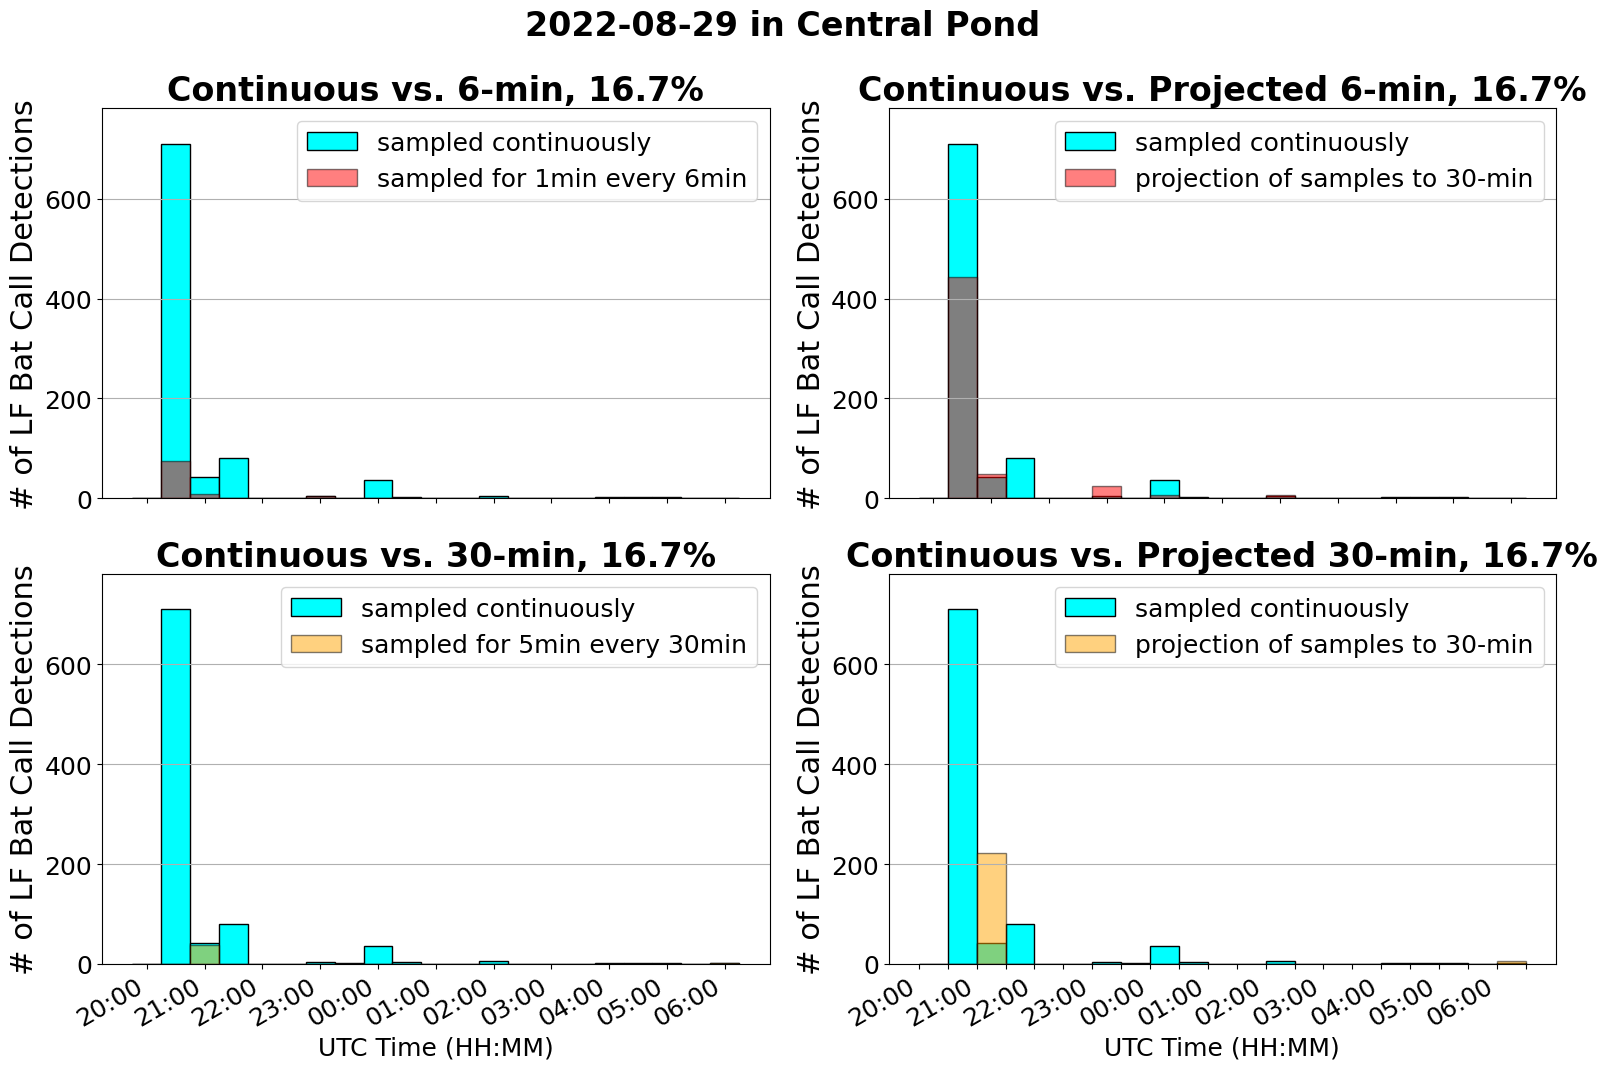

In [33]:
plt.figure(figsize=(16, 11))
plt.rcParams.update({'font.size': 18})
legend_loc = 1
plt.suptitle(f"{plot_date} in {location}", fontsize=24, fontweight='bold') 

plt.subplot(221)
plt.title(f"Continuous vs. 6-min, 16.7%", fontsize=24, fontweight='bold')
plt.ylabel("# of LF Bat Call Detections", fontsize=22)
plt.xlabel("UTC Time (HH:MM)")
plt.bar(datetime_info, height=num_c_lfdets, width=1, label="sampled continuously", color=continuous_bar_color, edgecolor=bar_edgecolor)
plt.bar(datetime_info, height=num_lfdets1, width=1, label="sampled for 1min every 6min", color=comparison_6min_bar_color, alpha=bar_alpha, edgecolor=bar_edgecolor)
plt.grid(axis="y")
plt.ylim(0, 1.1*max(np.max(num_c_lfdets), np.max(6*num_lfdets1), np.max(6*num_lfdets2)))
plt.legend(loc=legend_loc)
plt.xticks(np.arange(0, 22, 2), datetime_info[::2])

plt.subplot(222)
plt.title(f"Continuous vs. Projected 6-min, 16.7%", fontsize=24, fontweight='bold')
plt.ylabel("# of LF Bat Call Detections", fontsize=22)
plt.xlabel("UTC Time (HH:MM)")
plt.bar(datetime_info, height=num_c_lfdets, width=1, label="sampled continuously", color=continuous_bar_color, edgecolor=bar_edgecolor)
plt.bar(datetime_info, height=num_lfdets1*6, width=1, label="projection of samples to 30-min", color=comparison_6min_bar_color, alpha=bar_alpha, edgecolor=bar_edgecolor)
plt.grid(axis="y")
plt.ylim(0, 1.1*max(np.max(num_c_lfdets), np.max(6*num_lfdets1), np.max(6*num_lfdets2)))
plt.legend(loc=legend_loc)
plt.xticks(np.arange(0, 21, 2), datetime_info[::2])

plt.subplot(223)
plt.title(f"Continuous vs. 30-min, 16.7%", fontsize=24, fontweight='bold')
plt.ylabel("# of LF Bat Call Detections", fontsize=22)
plt.xlabel("UTC Time (HH:MM)")
plt.bar(datetime_info, height=num_c_lfdets, width=1, label="sampled continuously", color=continuous_bar_color, edgecolor=bar_edgecolor)
plt.bar(datetime_info, height=num_lfdets2, width=1, label="sampled for 5min every 30min", color=comparison_30min_bar_color, alpha=bar_alpha, edgecolor=bar_edgecolor)
plt.grid(axis="y")
plt.ylim(0, 1.1*max(np.max(num_c_lfdets), np.max(6*num_lfdets1), np.max(6*num_lfdets2)))
plt.legend(loc=legend_loc)
plt.xticks(np.arange(0, 22, 2), datetime_info[::2])

plt.subplot(224)
plt.title(f"Continuous vs. Projected 30-min, 16.7%", fontsize=24, fontweight='bold')
plt.ylabel("# of LF Bat Call Detections", fontsize=22)
plt.xlabel("UTC Time (HH:MM)")
plt.bar(datetime_info, height=num_c_lfdets, width=1, label="sampled continuously", color=continuous_bar_color, edgecolor=bar_edgecolor)
plt.bar(datetime_info, height=num_lfdets2*6, width=1, label="projection of samples to 30-min", color=comparison_30min_bar_color, alpha=bar_alpha, edgecolor=bar_edgecolor)
plt.grid(axis="y")
plt.ylim(0, 1.1*max(np.max(num_c_lfdets), np.max(6*num_lfdets1), np.max(6*num_lfdets2)))
plt.legend(loc=legend_loc)
plt.xticks(np.arange(c_presence_over_days.shape[1]+1)-0.5, new_date_info)
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.savefig(f'{Path.home()}/Documents/Research/Symposium/Figures/num_of_lf_detections__{location.split()[0]}_{dates[-1]}_030000to130000_comparisons.png')
plt.show()

In [34]:
num_c_hfdets
plot_c_hf_dist = np.zeros(len(num_hfdets2))
plot_hf1_dist = np.zeros(len(num_hfdets2))
plot_hf2_dist = np.zeros(len(num_hfdets2))

plot_c_hf_dist[3] = num_c_hfdets[3]
plot_hf1_dist[3] = num_hfdets1[3]
plot_hf2_dist[3] = num_hfdets2[3]

date_dist = datetime_info[3:5]
date_dist

['21:30', '22:00']

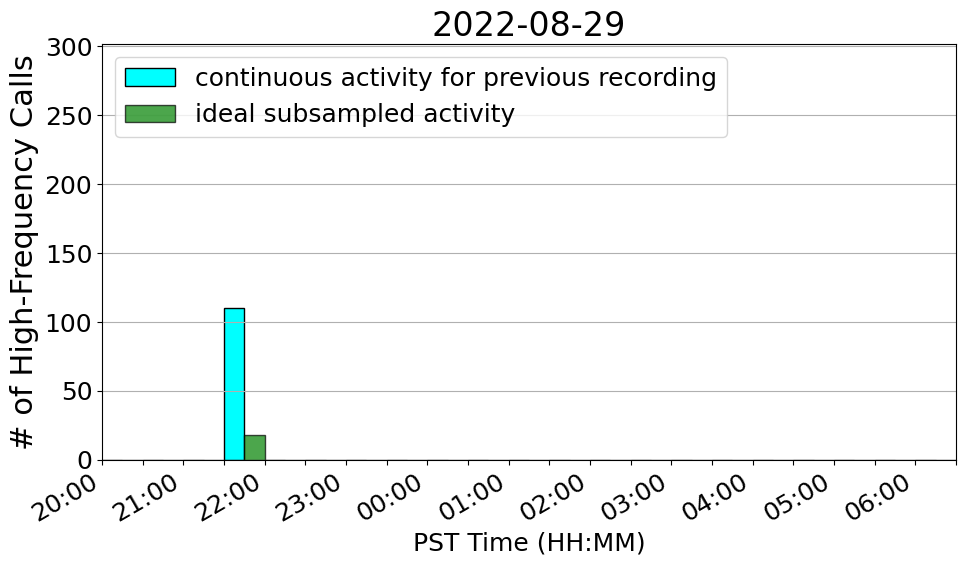

In [35]:
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 18})
# plt.suptitle(f"Detections of High-Frequency Activity", fontsize=24, fontweight='bold') 

# plt.subplot(121)
# plt.title(f"6-min, 16.7%", fontsize=24, fontweight='bold')
# plt.ylabel("% of Overestimation", fontsize=22)
# plt.xlabel("PST Time (HH:MM)")
# plt.plot((6*num_hfdets1 - num_c_hfdets)/num_c_hfdets)
# plt.bar(datetime_info, height=num_c_hfdets, width=1, label="sampled continuously", color=continuous_bar_color, edgecolor=bar_edgecolor)
# plt.bar(datetime_info, height=num_hfdets1, width=1, label="sampled for 1min every 6min", color=comparison_6min_bar_color, alpha=bar_alpha, edgecolor=bar_edgecolor)
# plt.grid(axis="y")
# plt.ylim(0, 1.1*max(np.max(num_c_hfdets), np.max(6*num_hfdets1), np.max(6*num_hfdets2)))
# plt.legend(loc=1)
# plt.xticks(np.arange(0, 21, 2), datetime_info[::2])

# plt.subplot(122)
plt.title(f"{plot_date}", fontsize=24)
plt.xlabel("PST Time (HH:MM)")
# plt.bar(np.arange(0, len(new_date_info)-1)0.333, height=plot_hf2_dist, width=0.33, label="5-min every 30-min", color='orange', edgecolor=bar_edgecolor)
# plt.bar(np.arange(0, len(new_date_info)-1), height=plot_hf1_dist, width=0.33, label="1-min every 6-min", color='red', edgecolor=bar_edgecolor)
plt.bar(np.arange(0, len(new_date_info)-1)-0.25, height=plot_c_hf_dist, width=0.5, label="continuous activity for previous recording", color=continuous_bar_color, edgecolor=bar_edgecolor)
# plt.bar(np.arange(0, len(datetime_info))-0.25, height=num_c_hfdets, width=bar_width, label="sampled continuously", color=continuous_bar_color, edgecolor=bar_edgecolor)
plt.bar(np.arange(0, len(datetime_info))+0.25, height=plot_c_hf_dist/6, width=bar_width, label="ideal subsampled activity", color='green', alpha=0.7, edgecolor=bar_edgecolor)
plt.grid(axis="y")
plt.ylabel("# of High-Frequency Calls", fontsize=22)
plt.ylim(0, 1.1*max(np.max(num_c_hfdets), np.max(num_hfdets1), np.max(num_hfdets2)))
plt.legend(loc=2)
# plt.axvline(1.5, ymax=0.55, linestyle='dashed', color='midnightblue', alpha=0.6)
# plt.axvline(7.5, ymax=0.55, linestyle='dashed', label="Time of Midnight", color='midnightblue', alpha=0.6)
# plt.axvline(17.5, ymax=0.55, linestyle='dashed', label="Time of Dawn", color='midnightblue', alpha=0.6)
# plt.text(1.5, 4350, "Dusk", color='midnightblue')
# plt.text(7.5, 4350, "Midnight", color='midnightblue')
# plt.text(17.5, 4350, "Dawn", color='midnightblue')
plt.xticks(np.arange(len(new_date_info))-0.5, new_date_info)
plt.gcf().autofmt_xdate()
plt.xlim(plt.xticks()[0][0], plt.xticks()[0][-1])

plt.tight_layout()
# plt.savefig(f'{Path.home()}/Documents/Research/Symposium/Figures/num_of_hf_detections__{location.split()[0]}_{dates[-1]}_030000to130000_comparisons.png')
plt.show()

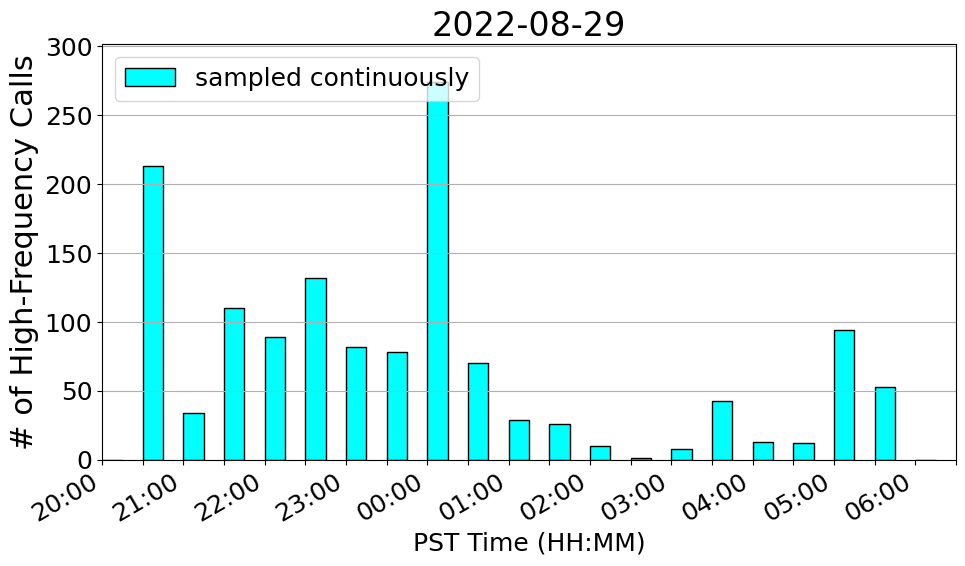

In [36]:
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 18})
# plt.suptitle(f"Detections of High-Frequency Activity", fontsize=24, fontweight='bold') 

# plt.subplot(121)
# plt.title(f"6-min, 16.7%", fontsize=24, fontweight='bold')
# plt.ylabel("% of Overestimation", fontsize=22)
# plt.xlabel("PST Time (HH:MM)")
# plt.plot((6*num_hfdets1 - num_c_hfdets)/num_c_hfdets)
# plt.bar(datetime_info, height=num_c_hfdets, width=1, label="sampled continuously", color=continuous_bar_color, edgecolor=bar_edgecolor)
# plt.bar(datetime_info, height=num_hfdets1, width=1, label="sampled for 1min every 6min", color=comparison_6min_bar_color, alpha=bar_alpha, edgecolor=bar_edgecolor)
# plt.grid(axis="y")
# plt.ylim(0, 1.1*max(np.max(num_c_hfdets), np.max(6*num_hfdets1), np.max(6*num_hfdets2)))
# plt.legend(loc=1)
# plt.xticks(np.arange(0, 21, 2), datetime_info[::2])

# plt.subplot(122)
plt.title(f"{plot_date}", fontsize=24)
plt.xlabel("PST Time (HH:MM)")
# plt.bar(np.arange(0, len(date_dist))-0.333, height=plot_hf2_dist, width=0.33, label="5-min every 30-min", color='orange', edgecolor=bar_edgecolor)
# plt.bar(np.arange(0, len(date_dist)), height=plot_hf1_dist, width=0.33, label="1-min every 6-min", color='red', edgecolor=bar_edgecolor)
# plt.bar(np.arange(0, len(date_dist))+0.333, height=plot_c_hf_dist, width=0.33, label="Continuous", color=continuous_bar_color, edgecolor=bar_edgecolor)
plt.bar(np.arange(0, len(datetime_info))-0.25, height=num_c_hfdets, width=bar_width, label="sampled continuously", color=continuous_bar_color, edgecolor=bar_edgecolor)
# plt.bar(np.arange(0, len(datetime_info))+0.25, height=num_c_hfdets, width=bar_width, label="extrapolation of ideal subsamples", color='green', alpha=0.7, edgecolor=bar_edgecolor)
plt.grid(axis="y")
plt.ylabel("# of High-Frequency Calls", fontsize=22)
plt.ylim(0, 1.1*max(np.max(num_c_hfdets), np.max(num_hfdets1), np.max(num_hfdets2)))
plt.legend(loc=2)
# plt.axvline(1.5, ymax=0.55, linestyle='dashed', color='midnightblue', alpha=0.6)
# plt.axvline(7.5, ymax=0.55, linestyle='dashed', label="Time of Midnight", color='midnightblue', alpha=0.6)
# plt.axvline(17.5, ymax=0.55, linestyle='dashed', label="Time of Dawn", color='midnightblue', alpha=0.6)
# plt.text(1.5, 4350, "Dusk", color='midnightblue')
# plt.text(7.5, 4350, "Midnight", color='midnightblue')
# plt.text(17.5, 4350, "Dawn", color='midnightblue')
plt.xticks(np.arange(len(new_date_info))-0.5, new_date_info)
plt.gcf().autofmt_xdate()
plt.xlim(plt.xticks()[0][0], plt.xticks()[0][-1])

plt.tight_layout()
# plt.savefig(f'{Path.home()}/Documents/Research/Symposium/Figures/num_of_hf_detections__{location.split()[0]}_{dates[-1]}_030000to130000_comparisons.png')
plt.show()

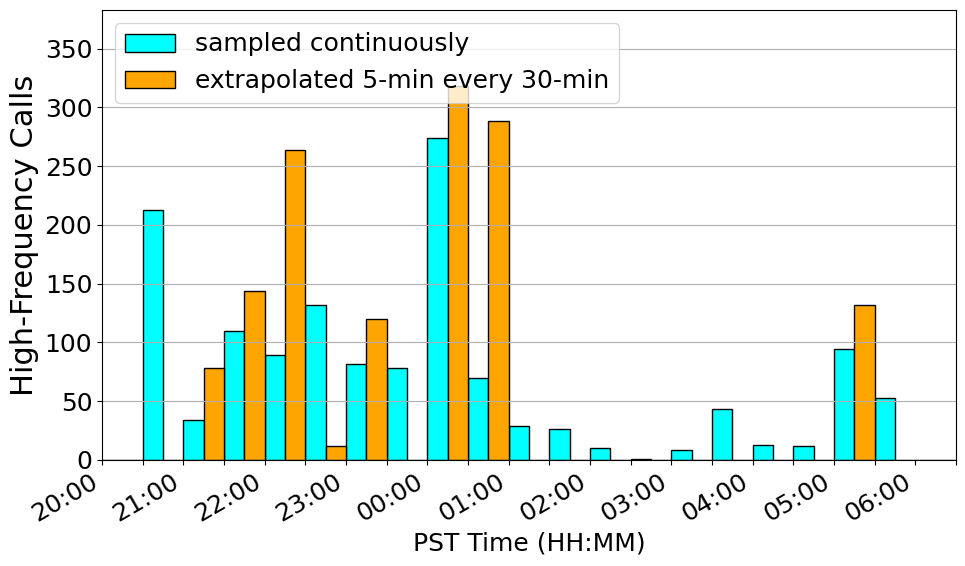

In [37]:
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 18})
# plt.suptitle(f"Detections of High-Frequency Activity", fontsize=24, fontweight='bold') 
# plt.title(f"Projected 5-min every 30-min", fontsize=24, fontweight='bold')
# plt.subplot(211)
plt.xlabel("PST Time (HH:MM)")
plt.ylabel("High-Frequency Calls", fontsize=22)
plt.bar(np.arange(0, len(datetime_info))-0.25, height=num_c_hfdets, width=bar_width, label="sampled continuously", color=continuous_bar_color, edgecolor=bar_edgecolor)
plt.bar(np.arange(0, len(datetime_info))+0.25, height=num_hfdets2*6, width=bar_width, label="extrapolated 5-min every 30-min", color=comparison_30min_bar_color, edgecolor=bar_edgecolor)
plt.grid(axis="y")
plt.ylim(0, 1.1*max(np.max(num_c_hfdets), np.max(6*num_hfdets1), np.max(6*num_hfdets2)))
plt.legend(loc=2)
plt.xticks(np.arange(len(new_date_info))-0.5, new_date_info)
# plt.axvline(1.5, ymax=0.55, linestyle='dashed', color='midnightblue', alpha=0.6)
# plt.axvline(7.5, ymax=0.55, linestyle='dashed', label="Time of Midnight", color='midnightblue', alpha=0.6)
# plt.axvline(17.5, ymax=0.55, linestyle='dashed', label="Time of Dawn", color='midnightblue', alpha=0.6)
# plt.text(1.5, 4350, "Dusk", color='midnightblue')
# plt.text(7.5, 4350, "Midnight", color='midnightblue')
# plt.text(17.5, 4350, "Dawn", color='midnightblue')
plt.xlim(plt.xticks()[0][0], plt.xticks()[0][-1])

# # plt.title(f"5-min every 30-min", fontsize=24, fontweight='bold')
# plt.ylabel("High-Frequency Calls", fontsize=22)
# plt.xlabel("PST Time (HH:MM)")
# # plt.plot((6*num_hfdets2 - num_c_hfdets)/num_c_hfdets)
# plt.bar(datetime_info, height=num_c_hfdets, width=1, label="sampled continuously", color=continuous_bar_color, edgecolor=bar_edgecolor)
# plt.bar(datetime_info, height=num_hfdets2, width=1, label="sampled for 5min every 30min", color=comparison_30min_bar_color, alpha=bar_alpha, edgecolor=bar_edgecolor)
# plt.grid(axis="y")
# plt.ylim(0, 1.1*max(np.max(num_c_hfdets), np.max(6*num_hfdets1), np.max(6*num_hfdets2)))
# plt.legend(loc=1)
# plt.xticks(np.arange(0, 21, 2), datetime_info[::2])

# plt.subplot(212)
# plt.xlabel("PST Time (HH:MM)")
# plt.bar(np.arange(0, len(datetime_info))-0.25, height=num_c_hfdets, width=bar_width, label="sampled continuously", color=continuous_bar_color, edgecolor=bar_edgecolor)
# plt.bar(np.arange(0, len(datetime_info))+0.25, height=num_hfdets1*6, width=bar_width, label="extrapolated 1-min every 6-min", color=comparison_6min_bar_color, edgecolor=bar_edgecolor)
# plt.grid(axis="y")
# plt.ylabel("High-Frequency Calls", fontsize=22)
# plt.ylim(0, 1.1*max(np.max(num_c_hfdets), np.max(6*num_hfdets1), np.max(6*num_hfdets2)))
# plt.legend(loc=2)
# plt.axvline(1.5, ymax=0.55, linestyle='dashed', color='midnightblue', alpha=0.6)
# plt.axvline(7.5, ymax=0.55, linestyle='dashed', label="Time of Midnight", color='midnightblue', alpha=0.6)
# plt.axvline(17.5, ymax=0.55, linestyle='dashed', label="Time of Dawn", color='midnightblue', alpha=0.6)
# plt.text(1.5, 4350, "Dusk", color='midnightblue')
# plt.text(7.5, 4350, "Midnight", color='midnightblue')
# plt.text(17.5, 4350, "Dawn", color='midnightblue')
# plt.xticks(np.arange(len(new_date_info))-0.5, new_date_info)
# plt.xlim(plt.xticks()[0][0], plt.xticks()[0][-1])

plt.gcf().autofmt_xdate()
plt.tight_layout()
# plt.savefig(f'{Path.home()}/Documents/Research/Symposium/Figures/num_of_hf_detections__{location.split()[0]}_{dates[-1]}_030000to130000_comparisons.png')
plt.show()